<a href="https://colab.research.google.com/github/ruchibhadauria/machine-learning/blob/master/Tripadvisor%20Reviews/trip_advisor_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center><h1 style="border-radius: 25px; background: #49F7F8; width: 500px; height: 60px;">Introduction</h1></center>

In [ ]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import string
import re
import nltk
from nltk.corpus import stopwords as StopWords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss
from xgboost import XGBClassifier, Booster
import warnings
warnings.filterwarnings("ignore")
import joblib

## <center><h1 style="border-radius: 25px; background: #49F7F8; width: 500px; height: 60px;">Load Dataset</h1></center>

In [ ]:
# Loading the dataset
reviews_dataset = pd.read_csv("/content/jaipur_reviews.csv", header=None, names=['Review', 'Date of stay', 'Rating'])
reviews_dataset.head()

,Review,Date of stay,Rating
0,Good room better quality except cattle was not...,"Tushar Verma . Family Traveller . Feb 15, 2021",4
1,The 2 day stay was awesome. I didn't like the ...,"Abid Hussain Pir . Couple Traveller . Feb 11, ...",4
2,Hotel and its rooms are nice. Hotel’s location...,"gagan verma . Family Traveller . Oct 07, 2021",4
3,Despite submitting documents during web check-...,"Amit Rana . Solo Traveller . Jan 22, 2021",5
4,"Overall good stay - hygiene maintained, food q...","Ritu Dubey . Group Traveller . Dec 14, 2020",4


 **There are three columns namely, review, date of stay and rating.**
- Review column have the review given by the customer. We have to extract relevant words from the text.
- Date of stay column contains the month and year of the stay in the hotel. We can extract both month and year from the column.
- Rating column is the rating the customer gave to their stay at the hotel. We need to extract the numbers from the text.

In [ ]:
# Checking information about the dataset
reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10610 entries, 0 to 10609
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        10610 non-null  object
 1   Date of stay  10609 non-null  object
 2   Rating        10610 non-null  object
dtypes: object(3)
memory usage: 248.8+ KB


**There are a total of 15196 entries in the dataset. Date of stay column have 16 missing values.**

## <center><h1 style="border-radius: 25px; background: #49F7F8; width: 600px; height: 60px;">Data Preprocessing</h1></center>

In [ ]:
# Dropping all the rows with null values
reviews_dataset.dropna(inplace=True)

In [ ]:
# Dropping duplicate rows
reviews_dataset.drop_duplicates(inplace=True)

In [ ]:
# Checking information for the dataset after removing null value rows and duplicate rows
reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4270 entries, 0 to 10609
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        4270 non-null   object
 1   Date of stay  4270 non-null   object
 2   Rating        4270 non-null   object
dtypes: object(3)
memory usage: 133.4+ KB


**Number of rows after removing all the duplicates and null value rows is 12796.**

### Cleaning Rating column

In [ ]:
# Extracting rating value from the unclean rating column
reviews_dataset["Rating"] = reviews_dataset["Rating"].apply(lambda x: re.findall("\d", x)[0])
reviews_dataset

,Review,Date of stay,Rating
0,Good room better quality except cattle was not...,"Tushar Verma . Family Traveller . Feb 15, 2021",4
1,The 2 day stay was awesome. I didn't like the ...,"Abid Hussain Pir . Couple Traveller . Feb 11, ...",4
2,Hotel and its rooms are nice. Hotel’s location...,"gagan verma . Family Traveller . Oct 07, 2021",4
3,Despite submitting documents during web check-...,"Amit Rana . Solo Traveller . Jan 22, 2021",5
4,"Overall good stay - hygiene maintained, food q...","Ritu Dubey . Group Traveller . Dec 14, 2020",4
...,...,...,...
10605,Thanks Hilton for amazing hospitality and the ...,Date of stay: November 2019,5
10606,Got undivided attention all the time the staff...,Date of stay: November 2019,5
10607,I really enjoyed the time here at Hilton the s...,Date of stay: November 2019,5
10608,Wonderful place I have been amazed with the qu...,Date of stay: November 2019,5


In [ ]:
# Checking percentage of rows for each rating
reviews_dataset["Rating"].value_counts(normalize = True)

5    0.823419
4    0.112646
3    0.028103
1    0.020375
2    0.015457
Name: Rating, dtype: float64

In [ ]:
# Mapping positive, neutral and negative to rating values 
reviews_dataset["Sentiment"] = reviews_dataset["Rating"].map({"5":"Positive", "4":"Positive", "3":"Neutral", "2":"Negative", "1":"Negative"})

### Creating year of stay column

In [ ]:
# Creating a new column year of stay from our existing column date of stay
reviews_dataset["Year of stay"] = reviews_dataset["Date of stay"].apply(lambda x: "".join(re.findall("\d\d\d\d", x)))
reviews_dataset

,Review,Date of stay,Rating,Sentiment,Year of stay
0,Good room better quality except cattle was not...,"Tushar Verma . Family Traveller . Feb 15, 2021",4,Positive,2021
1,The 2 day stay was awesome. I didn't like the ...,"Abid Hussain Pir . Couple Traveller . Feb 11, ...",4,Positive,2021
2,Hotel and its rooms are nice. Hotel’s location...,"gagan verma . Family Traveller . Oct 07, 2021",4,Positive,2021
3,Despite submitting documents during web check-...,"Amit Rana . Solo Traveller . Jan 22, 2021",5,Positive,2021
4,"Overall good stay - hygiene maintained, food q...","Ritu Dubey . Group Traveller . Dec 14, 2020",4,Positive,2020
...,...,...,...,...,...
10605,Thanks Hilton for amazing hospitality and the ...,Date of stay: November 2019,5,Positive,2019
10606,Got undivided attention all the time the staff...,Date of stay: November 2019,5,Positive,2019
10607,I really enjoyed the time here at Hilton the s...,Date of stay: November 2019,5,Positive,2019
10608,Wonderful place I have been amazed with the qu...,Date of stay: November 2019,5,Positive,2019


### Creating month of stay column

In [ ]:
# Creating a month of stay column from date of stay column
reviews_dataset["Month of stay"] = reviews_dataset["Date of stay"].apply(lambda x: "".join(re.findall(r'(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)', x)))
reviews_dataset

,Review,Date of stay,Rating,Sentiment,Year of stay,Month of stay
0,Good room better quality except cattle was not...,"Tushar Verma . Family Traveller . Feb 15, 2021",4,Positive,2021,Feb
1,The 2 day stay was awesome. I didn't like the ...,"Abid Hussain Pir . Couple Traveller . Feb 11, ...",4,Positive,2021,Feb
2,Hotel and its rooms are nice. Hotel’s location...,"gagan verma . Family Traveller . Oct 07, 2021",4,Positive,2021,Oct
3,Despite submitting documents during web check-...,"Amit Rana . Solo Traveller . Jan 22, 2021",5,Positive,2021,Jan
4,"Overall good stay - hygiene maintained, food q...","Ritu Dubey . Group Traveller . Dec 14, 2020",4,Positive,2020,Dec
...,...,...,...,...,...,...
10605,Thanks Hilton for amazing hospitality and the ...,Date of stay: November 2019,5,Positive,2019,November
10606,Got undivided attention all the time the staff...,Date of stay: November 2019,5,Positive,2019,November
10607,I really enjoyed the time here at Hilton the s...,Date of stay: November 2019,5,Positive,2019,November
10608,Wonderful place I have been amazed with the qu...,Date of stay: November 2019,5,Positive,2019,November


In [ ]:
# Dropping all rows for which year is less than 2018
reviews_dataset.drop(reviews_dataset[reviews_dataset["Year of stay"] < '2018'].index, axis=0, inplace=True)

# Dropping all neutral sentiment rows
reviews_dataset.drop(reviews_dataset[reviews_dataset["Sentiment"] == "Neutral"].index, axis=0, inplace=True)

In [ ]:
# Checking information for the dataset after removing rows
reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3228 entries, 0 to 10609
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Review         3228 non-null   object
 1   Date of stay   3228 non-null   object
 2   Rating         3228 non-null   object
 3   Sentiment      3228 non-null   object
 4   Year of stay   3228 non-null   object
 5   Month of stay  3228 non-null   object
dtypes: object(6)
memory usage: 176.5+ KB


**After removing reviews before 2018 and neutral sentiment, remaining row number is 8293.**

In [ ]:
# Checking percentage of each sentiment in our dataset
reviews_dataset.Sentiment.value_counts(normalize=True)

Positive    0.97026
Negative    0.02974
Name: Sentiment, dtype: float64

**This is an imbalanced dataset as positive sentiment has more than 97.4% rows and negative sentiment has only 2.58% rows.**

In [ ]:
# Shuffling the dataset
reviews_dataset = reviews_dataset.sample(frac = 1)
reviews_dataset

,Review,Date of stay,Rating,Sentiment,Year of stay,Month of stay
2029,Fantastic service and very good food. Loved th...,Date of stay: November 2019,5,Positive,2019,November
260,"Being a loyalist to Marriot, Hilton, ITC, Taj ...",Date of stay: September 2021,4,Positive,2021,September
10386,The hotel is very good with all the required a...,Date of stay: January 2020,5,Positive,2020,January
9831,Dear Mr. Vishal Greetings from Wedding Partn...,Date of stay: September 2021,5,Positive,2021,September
1940,we checked in on 6th Jan 2020 as a guest in a...,Date of stay: January 2020,1,Negative,2020,January
...,...,...,...,...,...,...
2117,Firstly I would like to say it's a very good p...,Date of stay: October 2019,5,Positive,2019,October
10177,Excilent services such a wonderful stay very d...,Date of stay: March 2020,5,Positive,2020,March
9816,The expectations that you have with such a big...,Date of stay: March 2021,2,Negative,2021,March
9857,Food was very good .Hotel staff very friendly....,Date of stay: August 2021,5,Positive,2021,August


In [ ]:
# Dropping date of stay and rating column from our dataset
reviews_dataset.drop(['Date of stay', 'Rating'], axis=1, inplace=True)

### Function to preprocess the review column

In [ ]:
# Creating a function to preprocess data
def preprocess_data(text):
    """
    Returns text after removing numbers, punctuations, urls, emojis, html tags and lowercasing all the words in given text.
    """
    text = re.sub(r'[0-9]+', '', str(text))   # removing numbers
    text = re.sub(r'[^\w\s]', '', str(text))   # removing punctuations
    text = " ".join(x.lower() for x in text.split())  # lower casing the text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # removing urls
    text = re.sub(r'<.*?>', '', text) # removing html tags
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = " ".join(x for x in text.split() if x not in STOPWORDS)
    return text

In [ ]:
# Applying preprocess_data function to review column
reviews_dataset["Preprocessed_reviews"] = reviews_dataset["Review"].apply(lambda x: preprocess_data(x))
reviews_dataset

,Review,Sentiment,Year of stay,Month of stay,Preprocessed_reviews
2029,Fantastic service and very good food. Loved th...,Positive,2019,November,fantastic service good food loved palace staff...
260,"Being a loyalist to Marriot, Hilton, ITC, Taj ...",Positive,2021,September,loyalist marriot hilton itc taj hotels family ...
10386,The hotel is very good with all the required a...,Positive,2020,January,hotel good required amenities friendly staff s...
9831,Dear Mr. Vishal Greetings from Wedding Partn...,Positive,2021,September,dear mr vishal greetings wedding partners alwa...
1940,we checked in on 6th Jan 2020 as a guest in a...,Negative,2020,January,checked th jan guest wedding group allocated r...
...,...,...,...,...,...
2117,Firstly I would like to say it's a very good p...,Positive,2019,October,firstly say good property stay mention service...
10177,Excilent services such a wonderful stay very d...,Positive,2020,March,excilent services wonderful stay delicious foo...
9816,The expectations that you have with such a big...,Negative,2021,March,expectations big brand met standard stayed hil...
9857,Food was very good .Hotel staff very friendly....,Positive,2021,August,food good hotel staff friendlyi really enjoyed...


### Creating a column for number of words in a review

In [ ]:
# Word count
reviews_dataset["Word_count"] = reviews_dataset["Review"].apply(lambda x: len(str(x).split()))
reviews_dataset.head()

,Review,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count
2029,Fantastic service and very good food. Loved th...,Positive,2019,November,fantastic service good food loved palace staff...,37
260,"Being a loyalist to Marriot, Hilton, ITC, Taj ...",Positive,2021,September,loyalist marriot hilton itc taj hotels family ...,132
10386,The hotel is very good with all the required a...,Positive,2020,January,hotel good required amenities friendly staff s...,61
9831,Dear Mr. Vishal Greetings from Wedding Partn...,Positive,2021,September,dear mr vishal greetings wedding partners alwa...,136
1940,we checked in on 6th Jan 2020 as a guest in a...,Negative,2020,January,checked th jan guest wedding group allocated r...,156


### Creating a column for number of unique words in a review

In [ ]:
# Unique word count
reviews_dataset["Unique_word_count"] = reviews_dataset["Review"].apply(lambda x: len(set(str(x).split())))
reviews_dataset.head()

,Review,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count
2029,Fantastic service and very good food. Loved th...,Positive,2019,November,fantastic service good food loved palace staff...,37,33
260,"Being a loyalist to Marriot, Hilton, ITC, Taj ...",Positive,2021,September,loyalist marriot hilton itc taj hotels family ...,132,100
10386,The hotel is very good with all the required a...,Positive,2020,January,hotel good required amenities friendly staff s...,61,56
9831,Dear Mr. Vishal Greetings from Wedding Partn...,Positive,2021,September,dear mr vishal greetings wedding partners alwa...,136,105
1940,we checked in on 6th Jan 2020 as a guest in a...,Negative,2020,January,checked th jan guest wedding group allocated r...,156,108


### Creating a column for number of stopwords in a review

In [ ]:
# Number of stop words in review
reviews_dataset["Stopword_count"] = reviews_dataset["Review"].apply(lambda x: len([w for w in str(x).lower().split() if w not in STOPWORDS]))
reviews_dataset.head()

,Review,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count
2029,Fantastic service and very good food. Loved th...,Positive,2019,November,fantastic service good food loved palace staff...,37,33,22
260,"Being a loyalist to Marriot, Hilton, ITC, Taj ...",Positive,2021,September,loyalist marriot hilton itc taj hotels family ...,132,100,72
10386,The hotel is very good with all the required a...,Positive,2020,January,hotel good required amenities friendly staff s...,61,56,39
9831,Dear Mr. Vishal Greetings from Wedding Partn...,Positive,2021,September,dear mr vishal greetings wedding partners alwa...,136,105,72
1940,we checked in on 6th Jan 2020 as a guest in a...,Negative,2020,January,checked th jan guest wedding group allocated r...,156,108,80


### Creating a column for average word length in a review

In [ ]:
# mean word length
reviews_dataset["Mean_word_length"] = reviews_dataset["Review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
reviews_dataset.head()

,Review,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count,Mean_word_length
2029,Fantastic service and very good food. Loved th...,Positive,2019,November,fantastic service good food loved palace staff...,37,33,22,5.243243
260,"Being a loyalist to Marriot, Hilton, ITC, Taj ...",Positive,2021,September,loyalist marriot hilton itc taj hotels family ...,132,100,72,4.787879
10386,The hotel is very good with all the required a...,Positive,2020,January,hotel good required amenities friendly staff s...,61,56,39,5.508197
9831,Dear Mr. Vishal Greetings from Wedding Partn...,Positive,2021,September,dear mr vishal greetings wedding partners alwa...,136,105,72,4.742647
1940,we checked in on 6th Jan 2020 as a guest in a...,Negative,2020,January,checked th jan guest wedding group allocated r...,156,108,80,4.025641


### Creating a column for number of character in a review

In [ ]:
#char count
reviews_dataset["Char_count"] = reviews_dataset["Review"].apply(lambda x: len(str(x)))
reviews_dataset.head()

,Review,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count,Mean_word_length,Char_count
2029,Fantastic service and very good food. Loved th...,Positive,2019,November,fantastic service good food loved palace staff...,37,33,22,5.243243,232
260,"Being a loyalist to Marriot, Hilton, ITC, Taj ...",Positive,2021,September,loyalist marriot hilton itc taj hotels family ...,132,100,72,4.787879,766
10386,The hotel is very good with all the required a...,Positive,2020,January,hotel good required amenities friendly staff s...,61,56,39,5.508197,396
9831,Dear Mr. Vishal Greetings from Wedding Partn...,Positive,2021,September,dear mr vishal greetings wedding partners alwa...,136,105,72,4.742647,788
1940,we checked in on 6th Jan 2020 as a guest in a...,Negative,2020,January,checked th jan guest wedding group allocated r...,156,108,80,4.025641,786


### Creating a column for number of punctuation in a review

In [ ]:
# punctuation count
reviews_dataset["Punctuation_count"] = reviews_dataset["Review"].apply(lambda x: len([p for p in str(x) if p in string.punctuation]))
reviews_dataset.head()

,Review,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count,Mean_word_length,Char_count,Punctuation_count
2029,Fantastic service and very good food. Loved th...,Positive,2019,November,fantastic service good food loved palace staff...,37,33,22,5.243243,232,7
260,"Being a loyalist to Marriot, Hilton, ITC, Taj ...",Positive,2021,September,loyalist marriot hilton itc taj hotels family ...,132,100,72,4.787879,766,19
10386,The hotel is very good with all the required a...,Positive,2020,January,hotel good required amenities friendly staff s...,61,56,39,5.508197,396,12
9831,Dear Mr. Vishal Greetings from Wedding Partn...,Positive,2021,September,dear mr vishal greetings wedding partners alwa...,136,105,72,4.742647,788,11
1940,we checked in on 6th Jan 2020 as a guest in a...,Negative,2020,January,checked th jan guest wedding group allocated r...,156,108,80,4.025641,786,18


## <center><h1 style="border-radius: 25px; background: #49F7F8; width: 800px; height: 60px;">Exploratory data analysis</h1></center>

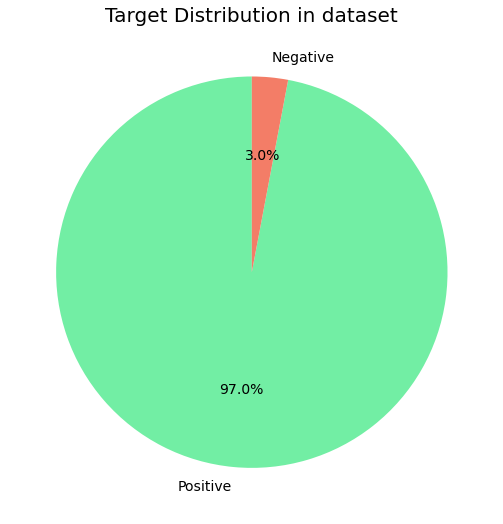

In [ ]:
# Creating a pie chart showing target distribution in dataset
plt.figure(figsize=(9, 9))
s = reviews_dataset['Sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, fontsize=14, colors=['#72EEA4', '#F37D67']);
s.set_ylabel('');
s.set_title('Target Distribution in dataset', fontsize=20);

In [ ]:
# Funtion for generating ngrams
def generate_ngrams(text, n_gram=1):
    """
    Returns ngrams for the given text.
    
    Parameters:
    text : for which we want ngrams
    n_gram : value for ngram
    """
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

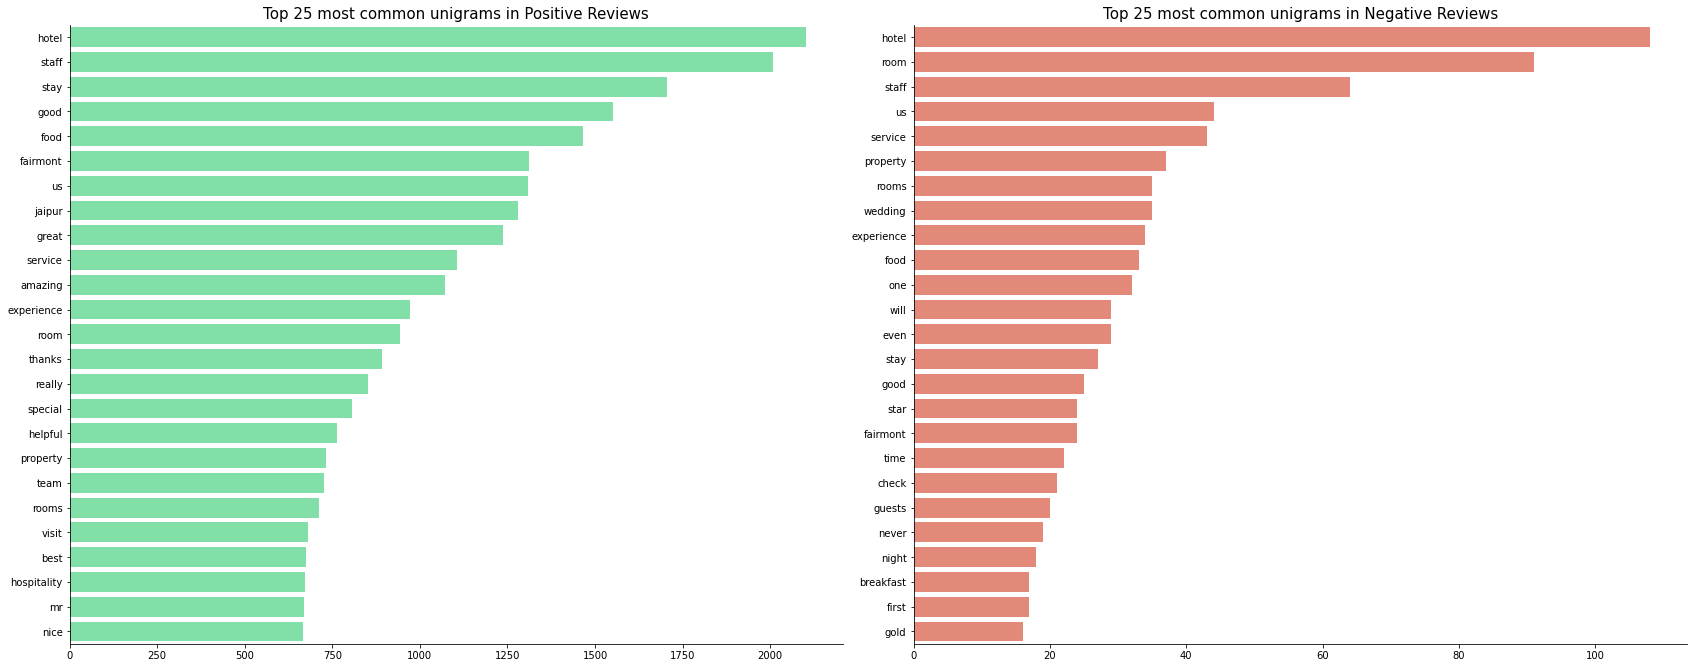

In [ ]:
# Creating a default dictionary for positive and negative unigrams
positive_unigrams = defaultdict(int)
negative_unigrams = defaultdict(int)

# Number of ngrams we want
N = 25

# Loop for updating value of positive_unigrams
for review in reviews_dataset['Preprocessed_reviews'][reviews_dataset['Sentiment']=="Positive"]:
    for word in generate_ngrams(review):
        positive_unigrams[word] += 1

for review in reviews_dataset['Preprocessed_reviews'][reviews_dataset['Sentiment']=="Negative"]:
    for word in generate_ngrams(review):
        negative_unigrams[word] += 1
        
# Creating dataframes using default dictionaries
df_positive_unigrams = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])
df_negative_unigrams = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])

        
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))
plt.tight_layout(pad=4.0)

# Plotting positive and negative unigrams dataset
sns.despine()
sns.barplot(y = df_positive_unigrams[0].values[:N], x = df_positive_unigrams[1].values[:N], ax=axes[0], color='#72EEA4')
sns.barplot(y = df_negative_unigrams[0].values[:N], x = df_negative_unigrams[1].values[:N], ax=axes[1], color='#F37D67')

axes[0].set_title(f'Top {N} most common unigrams in Positive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Negative Reviews', fontsize=15)

plt.show()

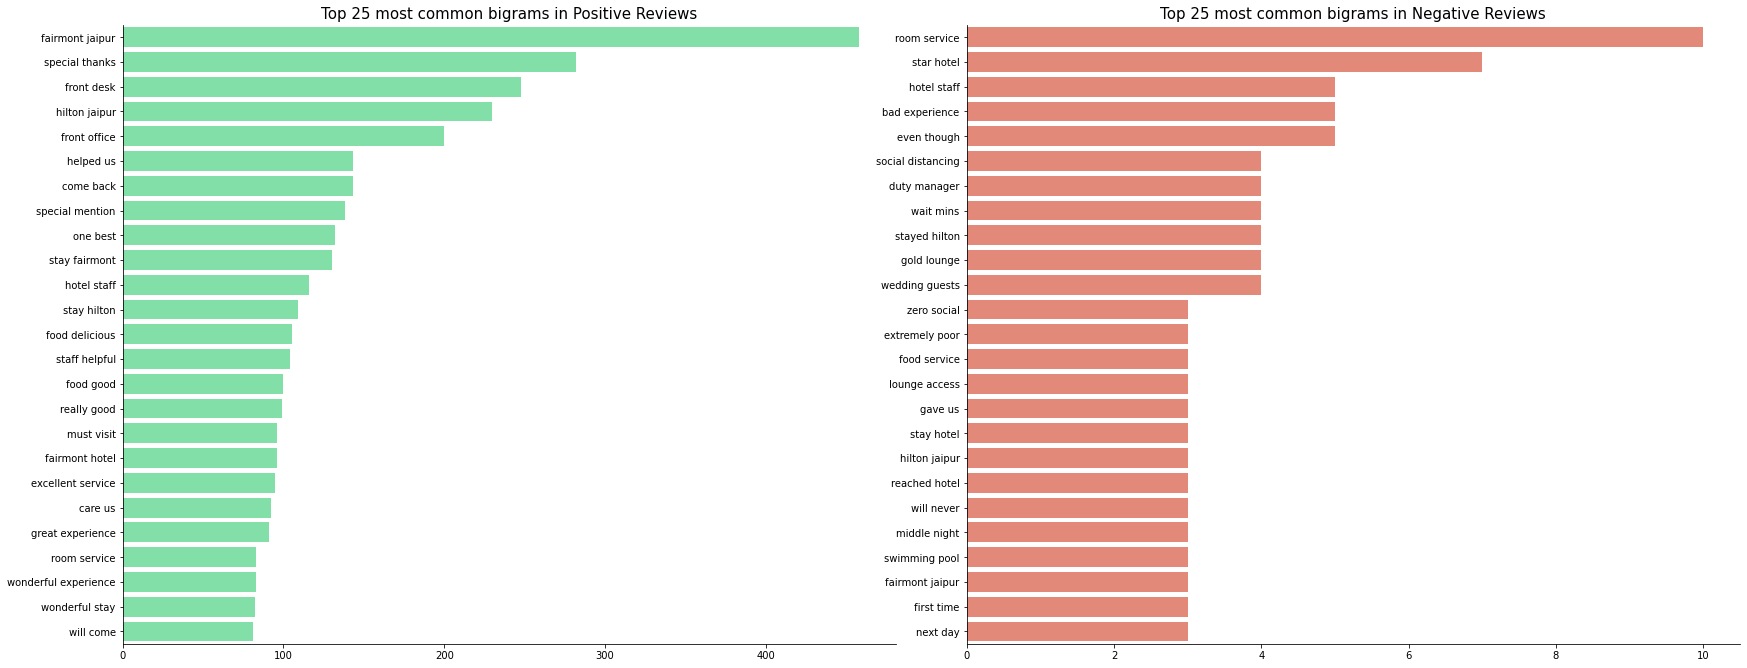

In [ ]:
# Creating a default dictionary for positive and negative bigrams
positive_bigrams = defaultdict(int)
negative_bigrams = defaultdict(int)

# Number of ngrams we want
N = 25

# Loop for updating values of bigrams in default dictionary
for review in reviews_dataset['Preprocessed_reviews'][reviews_dataset['Sentiment']=="Positive"]:
    for word in generate_ngrams(review, n_gram=2):
        positive_bigrams[word] += 1

for review in reviews_dataset['Preprocessed_reviews'][reviews_dataset['Sentiment']=="Negative"]:
    for word in generate_ngrams(review, n_gram=2):
        negative_bigrams[word] += 1
        
# Creating a dataset using default dictionaries
df_positive_bigrams = pd.DataFrame(sorted(positive_bigrams.items(), key=lambda x: x[1])[::-1])
df_negative_bigrams = pd.DataFrame(sorted(negative_bigrams.items(), key=lambda x: x[1])[::-1])
        
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))
plt.tight_layout(pad=4.0)
 
# Plotting both positive and negative bigrams
sns.despine()
sns.barplot(y = df_positive_bigrams[0].values[:N], x = df_positive_bigrams[1].values[:N], ax=axes[0], color='#72EEA4')
sns.barplot(y = df_negative_bigrams[0].values[:N], x = df_negative_bigrams[1].values[:N], ax=axes[1], color='#F37D67')

axes[0].set_title(f'Top {N} most common bigrams in Positive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Negative Reviews', fontsize=15)

plt.show()

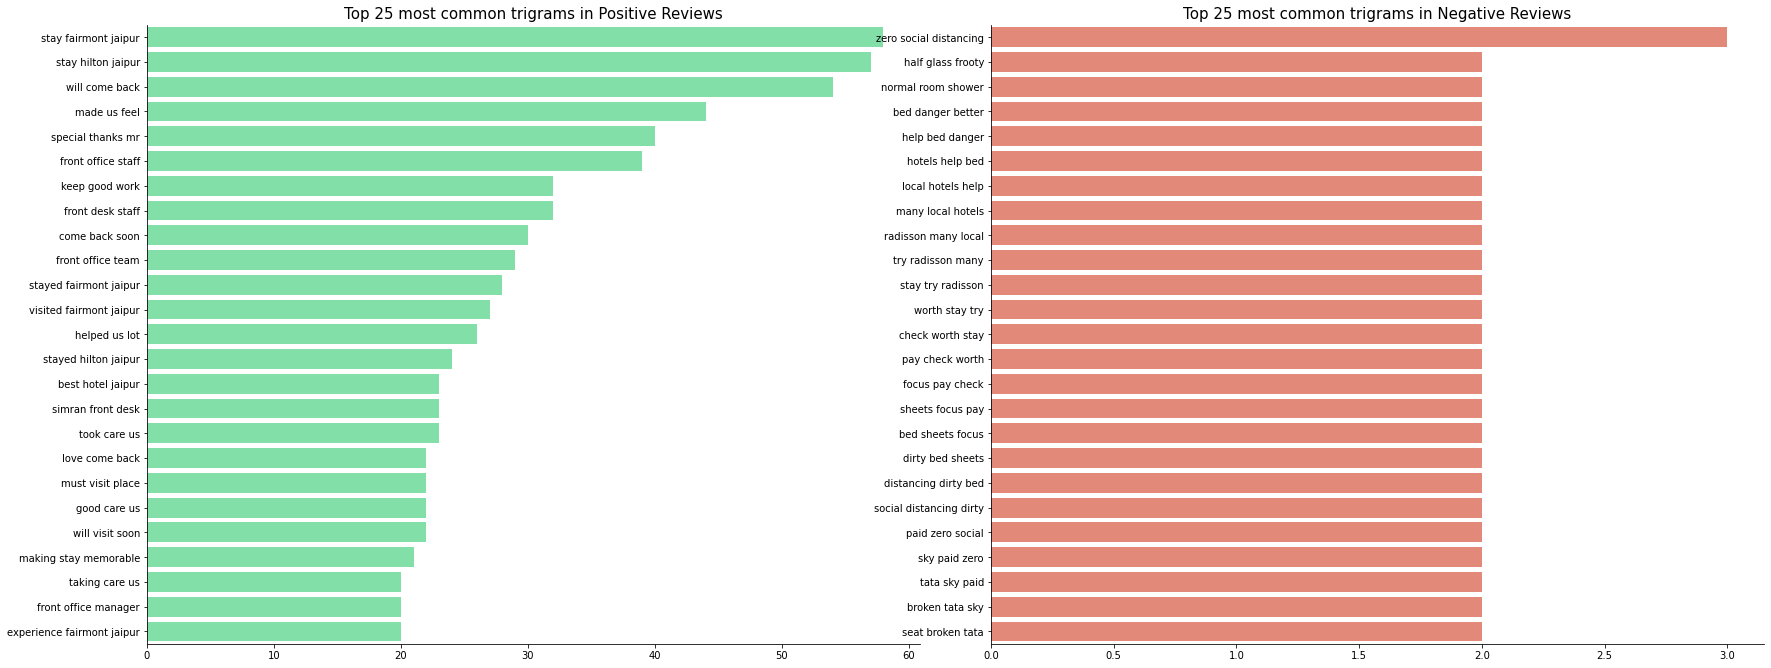

In [ ]:
# Creating default dictionary for positive and negative trigrams
positive_trigrams = defaultdict(int)
negative_trigrams = defaultdict(int)

# Number of ngrams we want
N = 25

# Loop for updating default dictionaries 
for review in reviews_dataset['Preprocessed_reviews'][reviews_dataset['Sentiment']=="Positive"]:
    for word in generate_ngrams(review, n_gram=3):
        positive_trigrams[word] += 1

for review in reviews_dataset['Preprocessed_reviews'][reviews_dataset['Sentiment']=="Negative"]:
    for word in generate_ngrams(review, n_gram=3):
        negative_trigrams[word] += 1
        
# Creating a dataframe using dictionaries
df_positive_trigrams = pd.DataFrame(sorted(positive_trigrams.items(), key=lambda x: x[1])[::-1])
df_negative_trigrams = pd.DataFrame(sorted(negative_trigrams.items(), key=lambda x: x[1])[::-1])
        
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))
plt.tight_layout(pad=4.0)
     
# Plotting positive and negative trigrams
sns.despine()
sns.barplot(y = df_positive_trigrams[0].values[:N], x = df_positive_trigrams[1].values[:N], ax=axes[0], color='#72EEA4')
sns.barplot(y = df_negative_trigrams[0].values[:N], x = df_negative_trigrams[1].values[:N], ax=axes[1], color='#F37D67')

axes[0].set_title(f'Top {N} most common trigrams in Positive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Negative Reviews', fontsize=15)

plt.show()

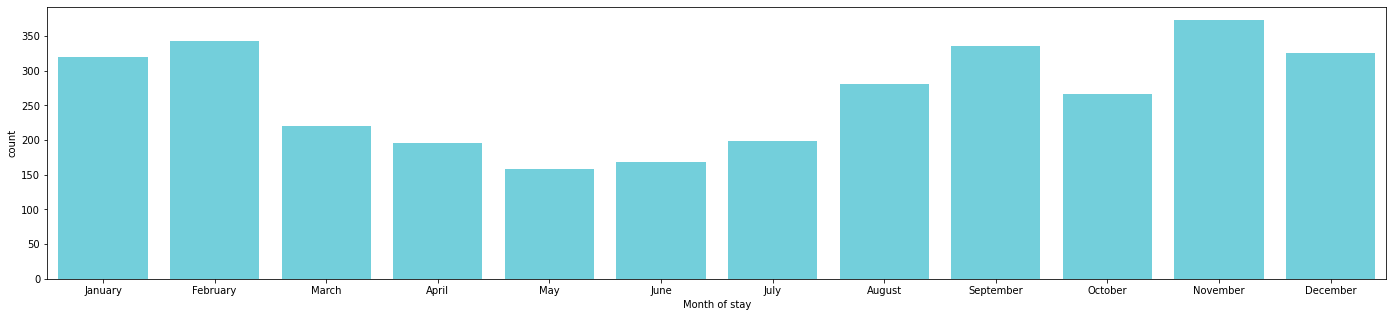

In [ ]:
# Plotting number of reviews in each month
plt.figure(figsize = (24, 5))
month =['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sns.despine()
sns.countplot(x="Month of stay", data=reviews_dataset, order=month, color='#62DCEC');

**Month of January and October has the highest number of reviews so we can say that number of people staying in hotel in these month is more compared to other months. Month of April has the  lowest number of reviews.**

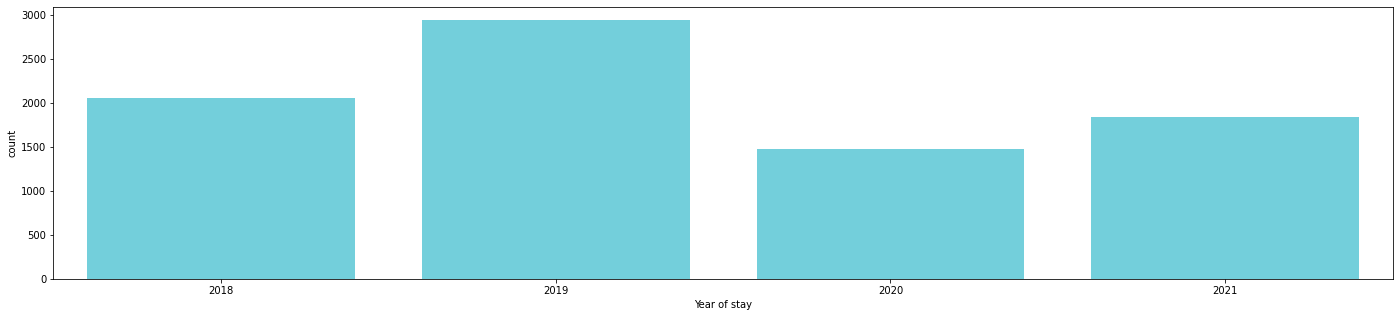

In [ ]:
# Plotting number of reviews for each year
plt.figure(figsize = (24, 5))
years = ['2018', '2019', '2020', '2021']
sns.despine()
sns.countplot(x="Year of stay", data=reviews_dataset, order=years, color='#62DCEC');

**2019 has the highest number of reviews whereas 2020 has the lowest because of global pandemic.**

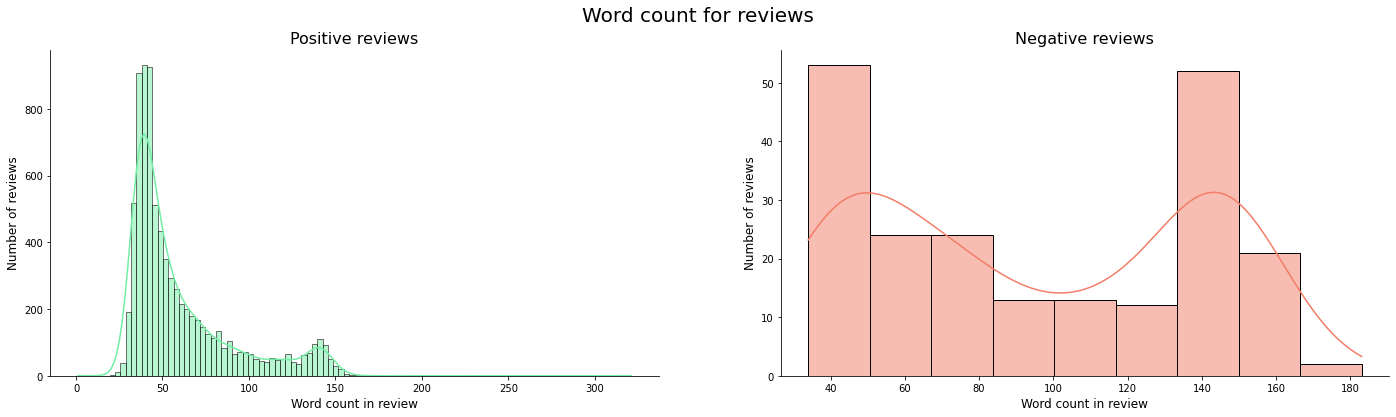

In [ ]:
# Plotting word count for reviews
fig, axes = plt.subplots(ncols = 2, figsize=(24, 6))

sns.despine()
sns.histplot(ax=axes[0], x="Word_count", data=reviews_dataset[reviews_dataset['Sentiment']=='Positive'], kde=True, color='#72EEA4');
sns.histplot(ax=axes[1], x="Word_count", data=reviews_dataset[reviews_dataset['Sentiment']=='Negative'], kde=True, color='#F37D67');

axes[0].set_title("Positive reviews", fontsize=16)
axes[1].set_title("Negative reviews", fontsize=16)

axes[0].set_ylabel("Number of reviews", fontsize=12)
axes[1].set_ylabel("Number of reviews", fontsize=12)
axes[0].set_xlabel("Word count in review", fontsize=12)
axes[1].set_xlabel("Word count in review", fontsize=12)

fig.suptitle("Word count for reviews", fontsize=20)
plt.show()

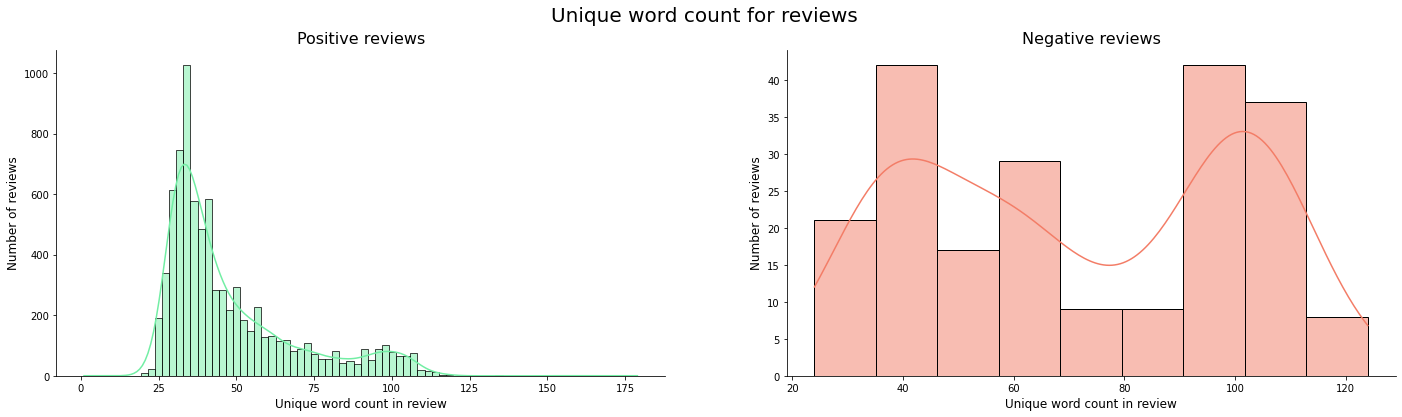

In [ ]:
# Plotting unique word count for reviews
fig, axes = plt.subplots(ncols = 2, figsize=(24, 6))

sns.despine()
sns.histplot(ax=axes[0], x="Unique_word_count", data=reviews_dataset[reviews_dataset['Sentiment']=='Positive'], kde=True, color='#72EEA4');
sns.histplot(ax=axes[1], x="Unique_word_count", data=reviews_dataset[reviews_dataset['Sentiment']=='Negative'], kde=True, color='#F37D67');

axes[0].set_title("Positive reviews", fontsize=16)
axes[1].set_title("Negative reviews", fontsize=16)

axes[0].set_ylabel("Number of reviews", fontsize=12)
axes[1].set_ylabel("Number of reviews", fontsize=12)
axes[0].set_xlabel("Unique word count in review", fontsize=12)
axes[1].set_xlabel("Unique word count in review", fontsize=12)

fig.suptitle("Unique word count for reviews", fontsize=20)
plt.show()

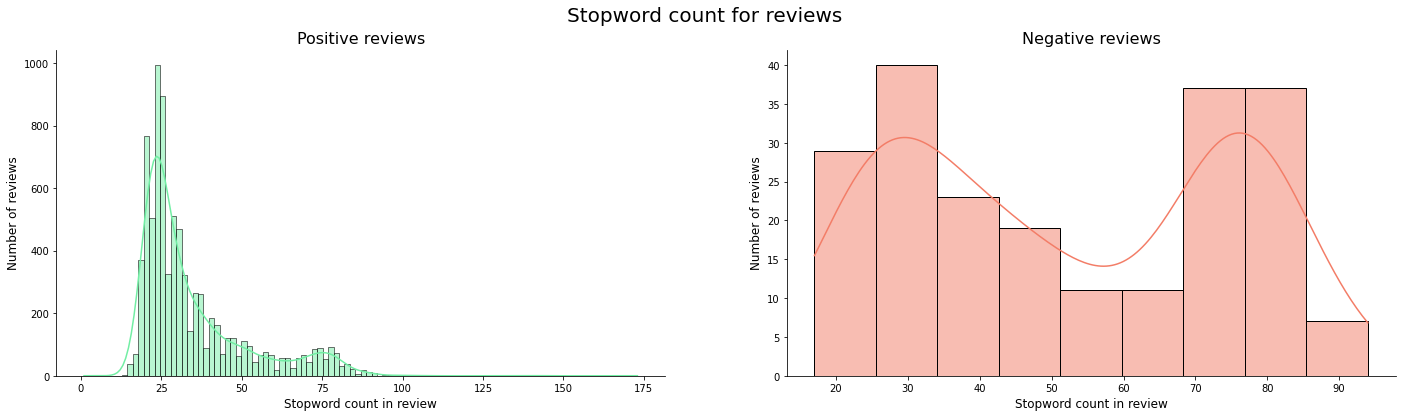

In [ ]:
# Plotting stopword count for reviews
fig, axes = plt.subplots(ncols = 2, figsize=(24, 6))

sns.despine()
sns.histplot(ax=axes[0], x="Stopword_count", data=reviews_dataset[reviews_dataset['Sentiment']=='Positive'], kde=True, color='#72EEA4');
sns.histplot(ax=axes[1], x="Stopword_count", data=reviews_dataset[reviews_dataset['Sentiment']=='Negative'], kde=True, color='#F37D67');

axes[0].set_title("Positive reviews", fontsize=16)
axes[1].set_title("Negative reviews", fontsize=16)

axes[0].set_ylabel("Number of reviews", fontsize=12)
axes[1].set_ylabel("Number of reviews", fontsize=12)
axes[0].set_xlabel("Stopword count in review", fontsize=12)
axes[1].set_xlabel("Stopword count in review", fontsize=12)

fig.suptitle("Stopword count for reviews", fontsize=20)
plt.show()

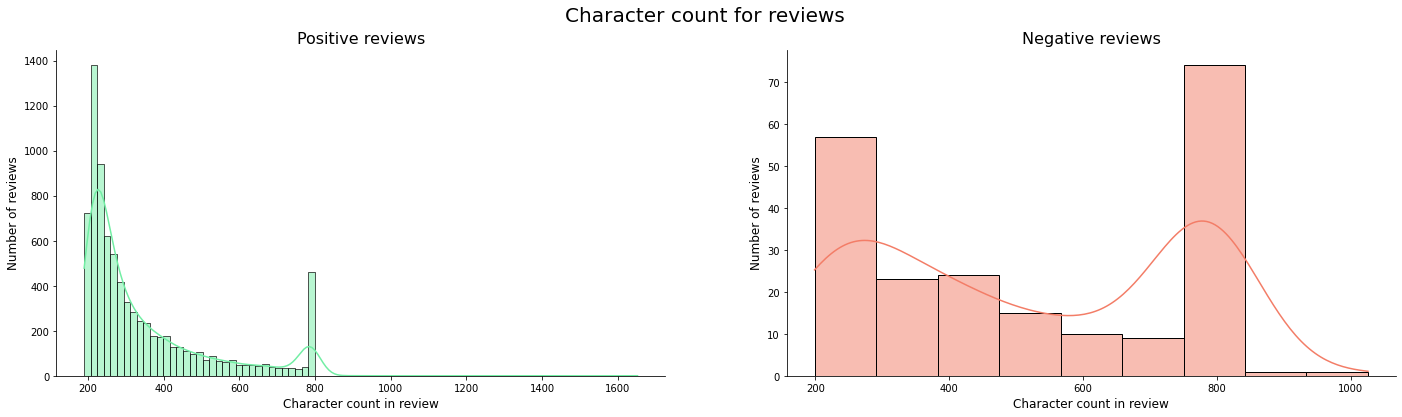

In [ ]:
# Plotting character count for reviews
fig, axes = plt.subplots(ncols = 2, figsize=(24, 6))

sns.despine()
sns.histplot(ax=axes[0], x="Char_count", data=reviews_dataset[reviews_dataset['Sentiment']=='Positive'], kde=True, color='#72EEA4');
sns.histplot(ax=axes[1], x="Char_count", data=reviews_dataset[reviews_dataset['Sentiment']=='Negative'], kde=True, color='#F37D67');

axes[0].set_title("Positive reviews", fontsize=16)
axes[1].set_title("Negative reviews", fontsize=16)

axes[0].set_ylabel("Number of reviews", fontsize=12)
axes[1].set_ylabel("Number of reviews", fontsize=12)
axes[0].set_xlabel("Character count in review", fontsize=12)
axes[1].set_xlabel("Character count in review", fontsize=12)

fig.suptitle("Character count for reviews", fontsize=20)
plt.show()

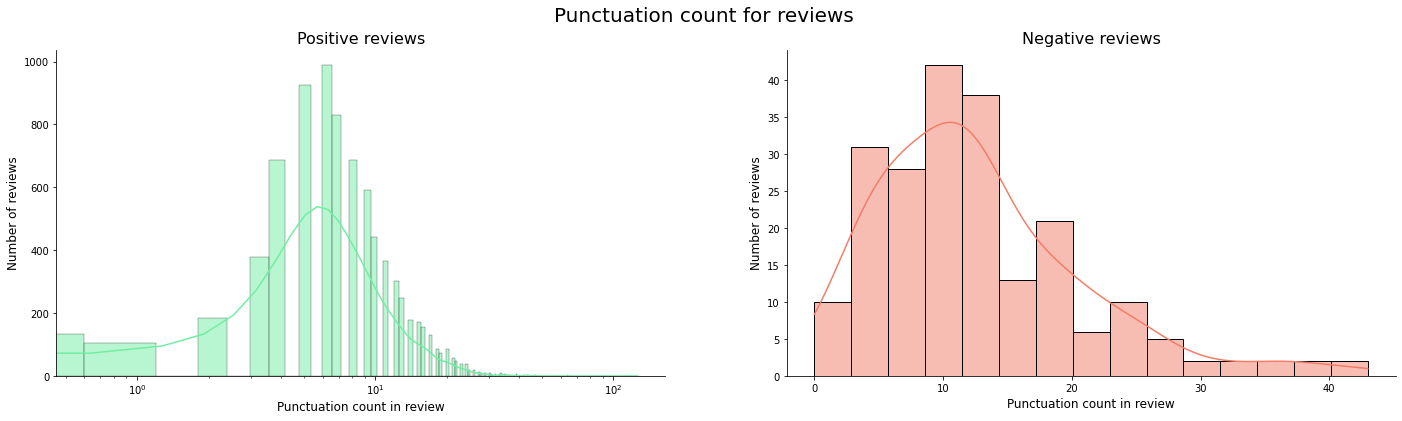

In [ ]:
# Plotting punctuation count for reviews
fig, axes = plt.subplots(ncols = 2, figsize=(24, 6))

sns.despine()
sns.histplot(ax=axes[0], x="Punctuation_count", data=reviews_dataset[reviews_dataset['Sentiment']=='Positive'], kde=True, color='#72EEA4');
sns.histplot(ax=axes[1], x="Punctuation_count", data=reviews_dataset[reviews_dataset['Sentiment']=='Negative'], kde=True, color='#F37D67');

axes[0].set_title("Positive reviews", fontsize=16)
axes[1].set_title("Negative reviews", fontsize=16)
axes[0].set_xscale('log')

axes[0].set_ylabel("Number of reviews", fontsize=12)
axes[1].set_ylabel("Number of reviews", fontsize=12)
axes[0].set_xlabel("Punctuation count in review", fontsize=12)
axes[1].set_xlabel("Punctuation count in review", fontsize=12)

fig.suptitle("Punctuation count for reviews", fontsize=20)
plt.show()

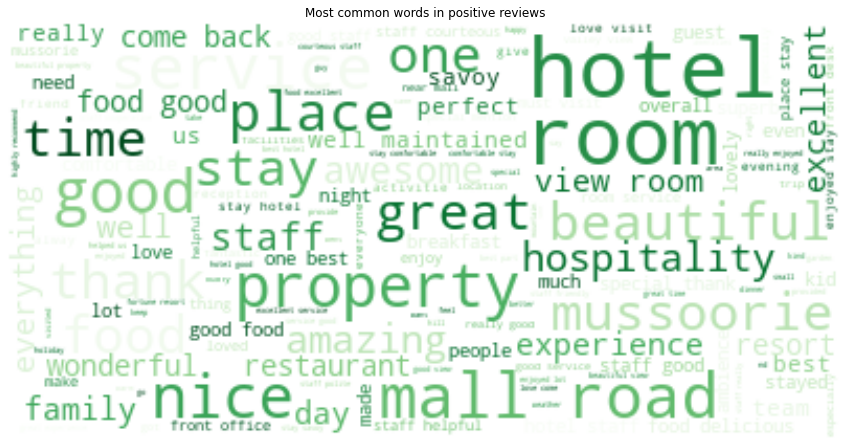

In [ ]:
# Plotting a wordcloud for positive reviews
positive = " ".join(review for review in reviews_dataset['Preprocessed_reviews'][reviews_dataset['Sentiment']=="Positive"])
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=500, max_font_size=40, random_state=42, colormap='Greens').generate(positive)
plt.figure(figsize=(15, 10))
plt.title("Most common words in positive reviews")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# # Plotting wordcloud for negative reviews
# mask = np.array(Image.open('../input/d/ruchibhadauria/hotel-reviews-from-tripadvisor/up.png'))
# transformed_mask = np.where(mask==0, 255, mask)

# positive = " ".join(review for review in reviews_dataset['Preprocessed_reviews'][reviews_dataset['Sentiment']=="Positive"])
# wc = WordCloud(background_color="white", max_words=1000, mask=transformed_mask, stopwords=STOPWORDS, max_font_size=40, colormap="Greens").generate(positive)

# plt.figure(figsize=(15, 30))
# plt.imshow(wc, interpolation='bilinear')
# plt.axis("off")
# plt.show()

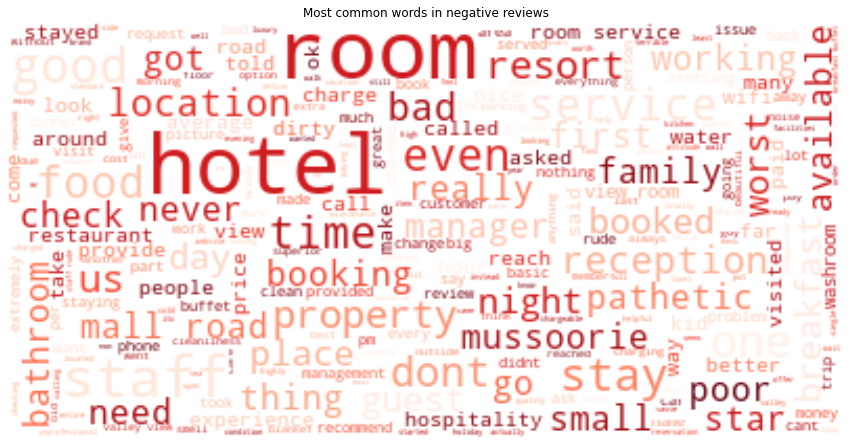

In [ ]:
# Plotting wordcloud for negative reviews
negative = " ".join(review for review in reviews_dataset['Preprocessed_reviews'][reviews_dataset['Sentiment']=="Negative"])
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=500, max_font_size=40, random_state=42, colormap = "Reds").generate(negative)
plt.figure(figsize=(15, 10))
plt.title("Most common words in negative reviews")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Create custom stop words
all_text = " ".join(list(reviews_dataset["Preprocessed_reviews"]))
words = pd.Series(all_text.split(" "))
frequent_words = words.value_counts()[:20]
frequent_words

staff        5996
hotel        5530
good         5226
stay         5069
food         4410
room         2789
property     2782
rooms        2696
great        2651
view         2573
nice         2333
us           2194
service      2173
amazing      2071
place        2032
also         2017
best         1927
excellent    1916
well         1883
mussoorie    1841
dtype: int64

In [ ]:
# Deleting top 10 frequent words from preprocessed_reviews
reviews_dataset["Preprocessed_reviews"] = reviews_dataset["Preprocessed_reviews"].apply(lambda x: " ".join([word for word in str(x).split() if word not in frequent_words]))
reviews_dataset

,Review,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count,Mean_word_length,Char_count,Punctuation_count
5230,"Food is awesome ,Everyone should prefer Superi...",Positive,2020,December,awesome everyone prefer superior himalayas bco...,48,43,33,5.166667,295,6
11797,"Awesome natural Hotel service excellent ,food...",Positive,2019,December,awesome natural services weather cold housekee...,33,25,23,5.515152,217,1
2129,A Memorable stay in a heritage hotel with oodl...,Positive,2018,October,memorable heritage oodles class highly recomme...,144,110,77,4.458333,790,17
10767,The stay was simply amazing . The ambience and...,Positive,2021,October,simply ambience aura dinner mesmerising prompt...,44,35,23,4.386364,237,6
13750,I visited Sterling Mussourie last month for a ...,Positive,2019,June,visited sterling mussourie last month vacation...,104,76,56,4.634615,586,9
...,...,...,...,...,...,...,...,...,...,...,...
4019,Recently visited the hotel. It became nightmar...,Negative,2018,June,recently visited became nightmare n family rea...,142,108,78,4.542254,786,19
8969,"I had an amazing stay time at this property, a...",Positive,2021,October,time scrumptious avijit really helpful kind th...,43,39,24,4.906977,253,5
4000,"Situated on the top, Dunsvirk Court is one of ...",Positive,2018,September,situated top dunsvirk court one ever visited f...,115,85,59,4.495652,638,9
1616,We had such a nice stay at sabit . Awesome pro...,Positive,2019,May,sabit awesome hospitality jain yr got everythi...,50,44,34,4.420000,270,8


In [ ]:
# Using label encoder to encode sentiment column
le = LabelEncoder()
reviews_dataset['Sentiment'] = le.fit_transform(reviews_dataset['Sentiment'])
reviews_dataset

,Review,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count,Mean_word_length,Char_count,Punctuation_count
5230,"Food is awesome ,Everyone should prefer Superi...",1,2020,December,awesome everyone prefer superior himalayas bco...,48,43,33,5.166667,295,6
11797,"Awesome natural Hotel service excellent ,food...",1,2019,December,awesome natural services weather cold housekee...,33,25,23,5.515152,217,1
2129,A Memorable stay in a heritage hotel with oodl...,1,2018,October,memorable heritage oodles class highly recomme...,144,110,77,4.458333,790,17
10767,The stay was simply amazing . The ambience and...,1,2021,October,simply ambience aura dinner mesmerising prompt...,44,35,23,4.386364,237,6
13750,I visited Sterling Mussourie last month for a ...,1,2019,June,visited sterling mussourie last month vacation...,104,76,56,4.634615,586,9
...,...,...,...,...,...,...,...,...,...,...,...
4019,Recently visited the hotel. It became nightmar...,0,2018,June,recently visited became nightmare n family rea...,142,108,78,4.542254,786,19
8969,"I had an amazing stay time at this property, a...",1,2021,October,time scrumptious avijit really helpful kind th...,43,39,24,4.906977,253,5
4000,"Situated on the top, Dunsvirk Court is one of ...",1,2018,September,situated top dunsvirk court one ever visited f...,115,85,59,4.495652,638,9
1616,We had such a nice stay at sabit . Awesome pro...,1,2019,May,sabit awesome hospitality jain yr got everythi...,50,44,34,4.420000,270,8


In [ ]:
# Splitting the dataset into training and testing dataset
xtrain, xtest, ytrain, ytest = train_test_split(reviews_dataset['Review'], reviews_dataset['Sentiment'], 
                                                  stratify=reviews_dataset['Sentiment'], 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [ ]:
# Splitting training dataset into training and validation dataset
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, 
                                                  stratify=ytrain, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

## <center><h1 style="border-radius: 25px; background: #49F7F8; width: 500px; height: 60px;">Model training</h1></center>

In [ ]:
# Initializing TfidfVectorizer
tfv = TfidfVectorizer(min_df=3,  max_features=None, decode_error = "replace", preprocessor = preprocess_data,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting Tfidf vectorizer to training dataset
tfv.fit(list(xtrain))

# Transforming the training and validation dataset 
xtrain_tfv = tfv.transform(xtrain)
xval_tfv = tfv.transform(xval)

In [ ]:
# Initializing XGBClassifier
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, max_depth=4, subsample= 1.0, min_child_weight=1, gamma= 0.5, colsample_bytree= 0.8, random_state=42)

# Fitting xgb on training dataset
xgb.fit(xtrain_tfv, ytrain)

# Making predictions on validation dataset
predictions = xgb.predict_proba(xval_tfv)
print ("logloss: %0.3f " % log_loss(yval, predictions))

ypred_xg = xgb.predict(xval_tfv)
print(classification_report(yval, ypred_xg))

logloss: 0.028 
              precision    recall  f1-score   support

           0       0.92      0.65      0.76        17
           1       0.99      1.00      0.99       647

    accuracy                           0.99       664
   macro avg       0.95      0.82      0.88       664
weighted avg       0.99      0.99      0.99       664



**XGBClassifier gives a log loss of 0.034 and F1-score for negative reviews is 0.69 and for positive reviews it is 0.99.**

## <center><h1>Model evaluation</h1></center>

In [ ]:
# Transfroming test dataset using the same tfidf vectorizer we fit on training dataset
xtest_tfv = tfv.transform(xtest)

In [ ]:
# Making prediction on testing dataset 
predictions = xgb.predict_proba(xtest_tfv)
print ("logloss: %0.3f " % log_loss(ytest, predictions))
ypred_xg = xgb.predict(xtest_tfv)
print(classification_report(ytest, ypred_xg))

logloss: 0.042 
              precision    recall  f1-score   support

           0       0.85      0.51      0.64        43
           1       0.99      1.00      0.99      1616

    accuracy                           0.98      1659
   macro avg       0.92      0.75      0.81      1659
weighted avg       0.98      0.98      0.98      1659



**For test dataset we get a log loss of 0.051 and F1 score for negative reviews is 0.68 and for positive reviews is 0.99.**

## <center><h1>Saving the model</h1></center>

In [ ]:
# save
Booster.save_model('xgb_clf.pkl')

TypeError: ignored

In [ ]:
xgb.save_model('x_c.json')